# **M Anwaar Khan**
# **BS: Data Science**
# **Linkedin:** https://www.linkedin.com/in/anwaar-khan-3b4975218

# **::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::**

# **Breast Tumor Detection Using CNN Model**

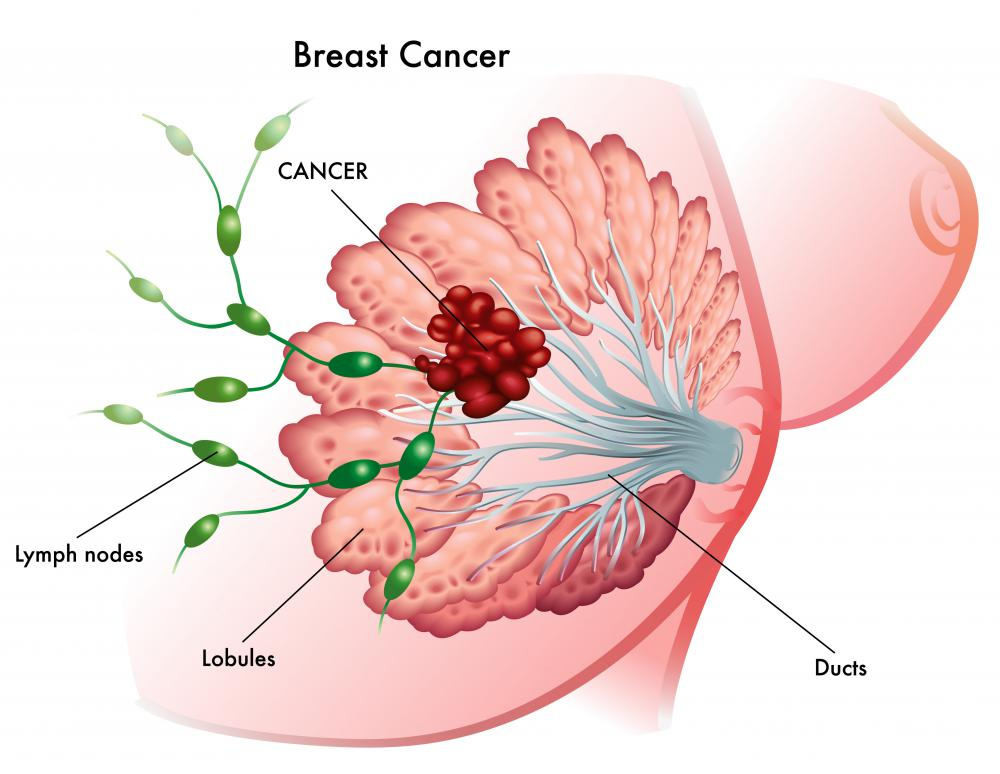

# **Libraries**

In [1]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Corrected import statement
from tensorflow.keras.layers import Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

# **Class for Loading and Splitting Datasets**

In [2]:
class BreasttumorDataset:
    def __init__(self, dataDir):
        self.data_dir = dataDir
   
    def dataPaths(self):
        filepaths = []
        labels = []
        folds = os.listdir(self.data_dir)
        for fold in folds:
            foldPath = os.path.join(self.data_dir, fold)
            filelist = os.listdir(foldPath)
            for file in filelist:
                fpath = os.path.join(foldPath, file)
                filepaths.append(fpath)
                labels.append(fold)
        return filepaths, labels
  
    def dataFrame(self, files, labels):

        Fseries = pd.Series(files, name='filepaths')
        Lseries = pd.Series(labels, name='labels')
        return pd.concat([Fseries, Lseries], axis=1)
   
    def split_(self):
        files, labels = self.dataPaths()
        df = self.dataFrame(files, labels)
        strat = df['labels']
        trainData, dummyData = train_test_split(df, train_size=0.8, shuffle=True, random_state=42, stratify=strat)
        strat = dummyData['labels']
        validData, testData = train_test_split(dummyData, train_size=0.5, shuffle=True, random_state=42, stratify=strat)
        return trainData, validData, testData

# **Load the imag Dataset**

In [3]:
df= r'E:\image_data_sets\Breast_data'

In [4]:
from sklearn.model_selection import train_test_split

dataSplit = BreasttumorDataset(df)
train_data, valid_data, test_data = dataSplit.split_()

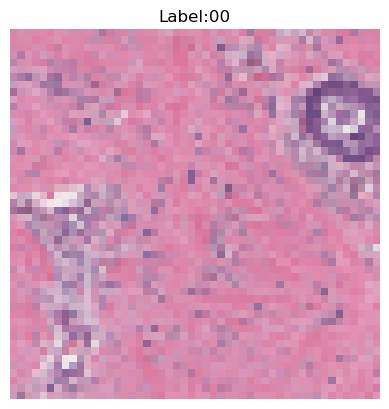

In [5]:
def display_random_image(df):
    random_row = df.sample(1).iloc[0]
    filepath = random_row['filepaths']
    label = random_row['labels']
    
    img = Image.open(filepath)
    plt.imshow(img)
    plt.title(f'Label:{label}')
    plt.axis('off')
    plt.show()

display_random_image(train_data)

# **Preprocessing**

In [6]:
# Define rescaling layer
rescale = tf.keras.layers.Rescaling(1./255)

# Load train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory="E:\image_data_sets\Breast_data",
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset="training",
    seed=123,
    label_mode='categorical',  # Assuming you have multiple classes
)

# Preprocess train dataset (rescale)
train_ds = train_ds.map(lambda x, y: (rescale(x), y))

# Load validation dataset
validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory="E:\image_data_sets\Breast_data",
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset="validation",
    seed=123,
    label_mode='categorical',  # Assuming you have multiple classes
)

# Preprocess validation dataset (rescale)
validation_ds = validation_ds.map(lambda x, y: (rescale(x), y))

# Load test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory="E:\image_data_sets\Breast_data",  # Specify the directory for the test dataset
    batch_size=32,
    image_size=(256, 256),
    label_mode='categorical',  # Assuming you have multiple classes
    shuffle=False,
)

# Preprocess test dataset (rescale)
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

Found 39701 files belonging to 2 classes.
Using 31761 files for training.
Found 39701 files belonging to 2 classes.
Using 7940 files for validation.
Found 39701 files belonging to 2 classes.


# **Shape**

In [7]:
# Check the first image shape in the training dataset
print("Shape of the first image in the training dataset:", next(iter(train_ds))[0][0].shape)
# Check the first image shape in the validation dataset
print("Shape of the first image in the validation dataset:", next(iter(validation_ds))[0][0].shape)
# Check the first image shape in the test dataset
print("Shape of the first image in the test dataset:", next(iter(test_ds))[0][0].shape)

Shape of the first image in the training dataset: (256, 256, 3)
Shape of the first image in the validation dataset: (256, 256, 3)
Shape of the first image in the test dataset: (256, 256, 3)


# **Pixel Value**

In [8]:
# Initialize variables to store minimum and maximum pixel values
min_pixel_value = float('inf')
max_pixel_value = float('-inf')

# Iterate through the dataset
for images, _ in train_ds:
    # Compute the minimum and maximum pixel values in the current batch of images
    batch_min = tf.reduce_min(images)
    batch_max = tf.reduce_max(images)
    
    # Update overall minimum and maximum pixel values
    min_pixel_value = tf.minimum(min_pixel_value, batch_min)
    max_pixel_value = tf.maximum(max_pixel_value, batch_max)

# Print the minimum and maximum pixel values
print("Minimum pixel value:", min_pixel_value.numpy())
print("Maximum pixel value:", max_pixel_value.numpy())

Minimum pixel value: 0.0012789858
Maximum pixel value: 1.0


# **Visualization**

In [9]:
def visualize_images(path, target_size=(256, 256), num_images=5):

    # Get a list of image filenames
    image_filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

    if not image_filenames:
        raise ValueError("No images found in the specified path")

    # Select random images
    selected_images = random.sample(image_filenames, min(num_images, len(image_filenames)))

    # Create a figure and axes
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    # Display each image
    for i, image_filename in enumerate(selected_images):
        # Load image and resize
        image_path = os.path.join(path, image_filename)
        image = Image.open(image_path)
        image = image.resize(target_size)

        # Display image
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_filename)  # Set image filename as title

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# **00**

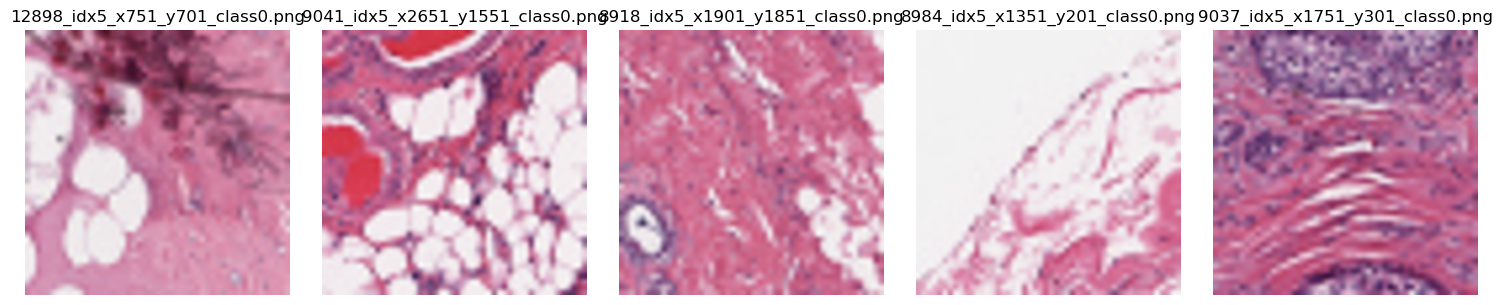

In [10]:
path_to_visualize = "E:/image_data_sets/Breast_data/00"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)


# **01**

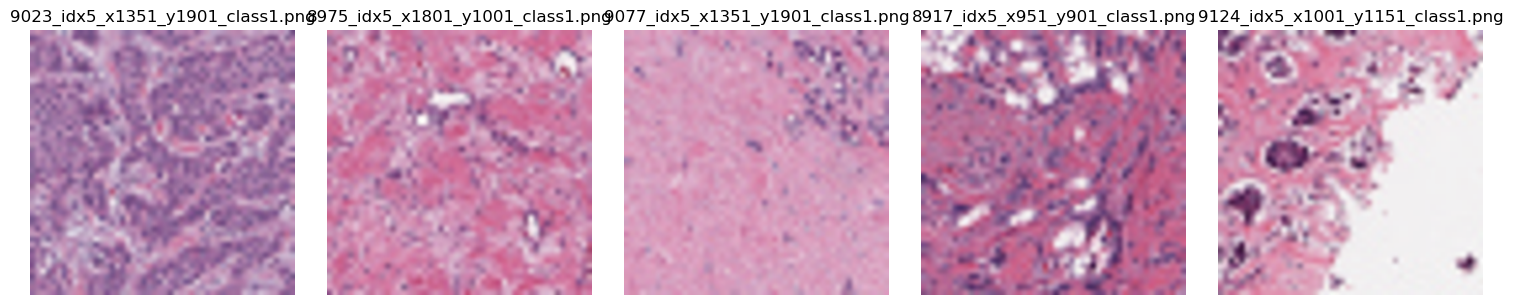

In [11]:
path_to_visualize = "E:/image_data_sets/Breast_data/01"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

# **Build Model**

In [12]:
# Define the CNN model
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
])

# **Compile the model**

In [13]:
# Compile the model
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# **Fit Model**

In [14]:
cnn_model.add(Dense(2, activation='softmax'))  # if there are 2 classes

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Example model architecture for binary classification
model = Sequential([Dense(2, activation='softmax')])  # Output layer with 2 neurons for binary classification

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# **Train the model**

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model
history = cnn_model.fit(train_ds,
                        validation_data=validation_ds,
                        epochs=5,
                        callbacks=[early_stopping])

Epoch 1/5
575/993 ━━━━━━━━━━━━━━━━━━━━ 6:46 973ms/step - accuracy: 0.7599 - loss: 0.5512

# **Evaluate the model**

In [17]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = cnn_model.evaluate(test_ds)
print("Test accuracy:", test_accuracy)

1241/1241 ━━━━━━━━━━━━━━━━━━━━ 297s 239ms/step - accuracy: 0.9681 - loss: 0.3062
Test accuracy: 0.7595526576042175


# **History Plot**

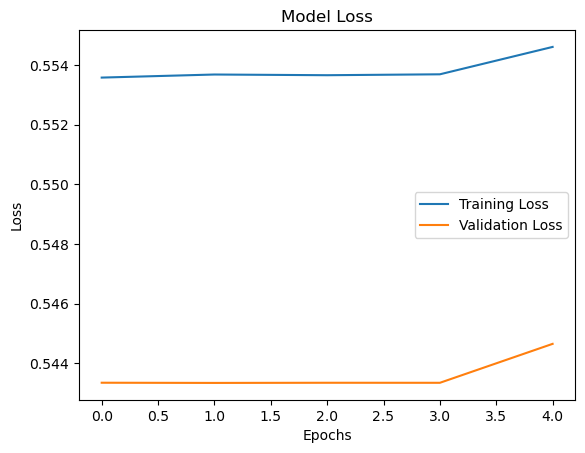

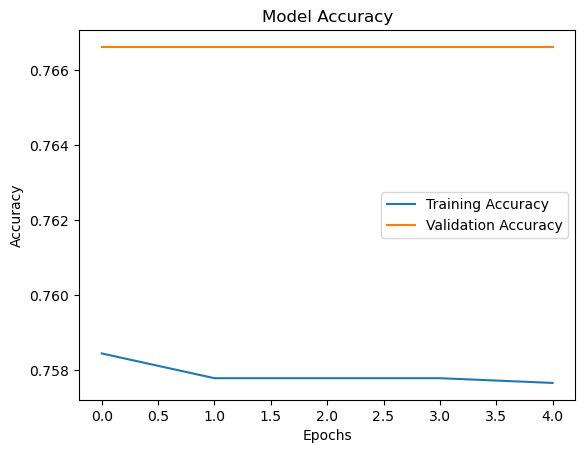

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()